In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
%matplotlib inline

# Expected Exposure simulation with QuantLib and Python

In [2]:
today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)

In [3]:
# Setup Marketdata
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
euribor6m = ql.Euribor6M(hyts)

In [248]:
# Setup a dummy portfolio with one Swap
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 1Y
    
    parameter:
        
        start (ql.Date) : Start Date
        
        maturity (ql.Period) : SwapTenor
        
        nominal (float) : Nominal
        
        fixedRate (float) : rate paid on fixed leg
        
        index (ql.IborIndex) : Index
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start, end, fixedLegTenor, index.fixingCalendar(), fixedLegBDC, fixedLegBDC, ql.DateGeneration.Backward, False)
    floatSchedule = ql.Schedule(start, end, index.tenor(), index.fixingCalendar(), index.businessDayConvention(), index.businessDayConvention(), ql.DateGeneration.Backward, False)
    swap = ql.VanillaSwap(typ, nominal, fixedSchedule, fixedRate, fixedLegDC, floatSchedule, index, spread, index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

portfolio = [makeSwap(today + ql.Period("2d"),ql.Period("5Y"),1e6, 0.03, euribor6m)#,
             #makeSwap(today + ql.Period("2d"),ql.Period("4Y"),5e5, 0.03, euribor6m, ql.VanillaSwap.Receiver),
            ]

In [249]:
engine = ql.DiscountingSwapEngine(hyts)

for deal, fixingDates in portfolio:
    deal.setPricingEngine(engine)
    print(deal.NPV())

2233.46835369


In [250]:
# Stochastic Process 

In [259]:
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.02))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)

In [260]:
process = model.stateProcess()

In [261]:
# Path Generation

date_grid = [today + ql.Period(i,ql.Weeks) for i in range(0,52*6)]
for deal in portfolio:
    date_grid += deal[1]

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

In [262]:
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(ql.MersenneTwisterUniformRsg(len(time_grid)-1,ql.MersenneTwisterUniformRng(1)))

In [263]:
N = 1500

x = np.zeros((N, len(time_grid)))
y = np.zeros((N, len(time_grid)))
for n in range(0,N):
    dWs = generator.nextSequence().value()
    for i in range(1, len(time_grid)):
        x[n,i] = process.expectation(time_grid[i-1], x[n,i-1], dt[i-1]) + dWs[i-1]*process.stdDeviation(time_grid[i-1], x[n,i-1], dt[i-1])
        y[n,i] = (x[n,i] - process.expectation(0,0,time_grid[i])) / process.stdDeviation(0,0,time_grid[i])

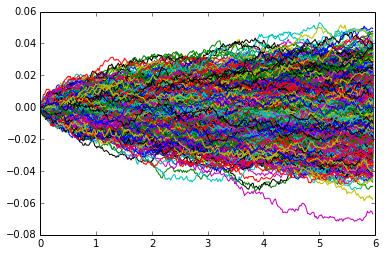

In [264]:
for i in range(0,N):
    plt.plot(time_grid, x[i,:])

In [265]:
npv_matrix = np.zeros((N,len(date_grid)))
for p in range(0,N):
    for t in range(0, len(date_grid)):
        date = date_grid[t]
        #ql.Settings.instance().setEvaluationDate(today)
        # update fixing
        x_p_t = y[p,t]
        zeroBonds = [model.zerobond(time_grid[t]+i, time_grid[t], x_p_t) for i in range(1,10)]
        ql.Settings.instance().setEvaluationDate(date)
        yc = ql.DiscountCurve([date] + [date+ql.Period(i,ql.Years) for i in range(1,10)], [1] + zeroBonds, ql.Actual365Fixed())
        yc.enableExtrapolation()
        hyts.linkTo(yc)
        if euribor6m.isValidFixingDate(date):
            fixing = -np.log(model.zerobond(time_grid[t]+0.5, time_grid[t], x_p_t)) / 0.5
            euribor6m.addFixing(date, fixing)
        for deal, fixing in portfolio:
            npv_matrix[p,t] += deal.NPV()
    ql.IndexManager.instance().clearHistories()
ql.Settings.instance().setEvaluationDate(today)
hyts.linkTo(yts)

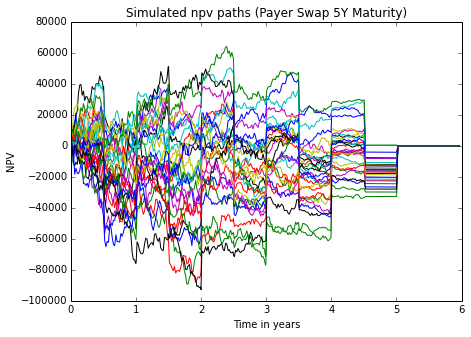

In [288]:
plt.figure(figsize=(7,5), dpi=300)
for i in range(0,30):
    plt.plot(time_grid, npv_matrix[i,:])
plt.xlabel("Time in years")
plt.ylabel("NPV")
plt.title("Simulated npv paths (Payer Swap 5Y Maturity)")

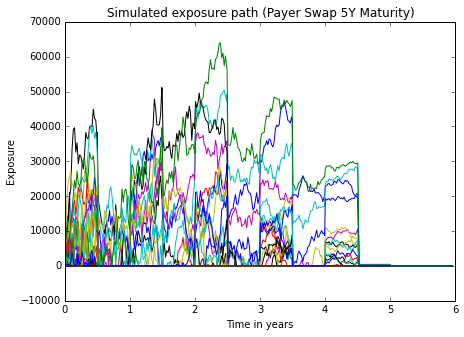

In [282]:
E = npv_matrix.copy()
E[E<0]=0
plt.figure(figsize=(7,5), dpi=600)
for i in range(0,30):
    plt.plot(time_grid, E[i,:])
plt.xlabel("Time in years")
plt.ylabel("Exposure")
plt.ylim([-10000,70000])
plt.title("Simulated exposure path (Payer Swap 5Y Maturity)")


In [289]:
EE = np.sum(E, axis=0)/N

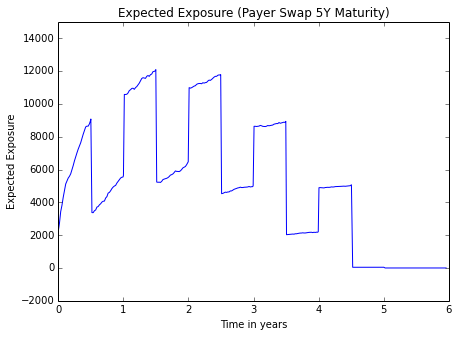

In [291]:
plt.figure(figsize=(7,5), dpi=300)
plt.plot(time_grid, EE)
plt.xlabel("Time in years")
plt.ylabel("Expected Exposure")
plt.ylim([-2000,15000])
plt.title("Expected Exposure (Payer Swap 5Y Maturity)")

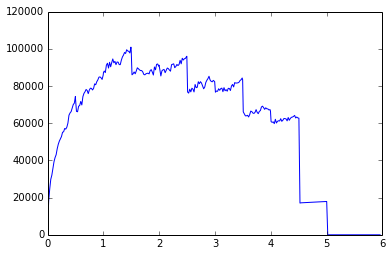

In [235]:
PFE_curve = np.apply_along_axis(lambda x: np.sort(x)[0.95*N],0, E)
plt.plot(time_grid,PFE_curve)

In [236]:
MPFE = np.max(PFE_curve)
MPFE

100881.46697697858

In [237]:
PFE = np.sort(np.max(E,axis=1))[0.95*N]
PFE

138447.94740496032